<a href="https://colab.research.google.com/github/MahdiTheGreat/Financial-Instrument-sentiment-Analysis/blob/main/Auto_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pmdarima backtrader pipdeptree
!pip uninstall numpy -y
!pip install numpy==1.26.3

Found existing installation: numpy 1.26.3
Uninstalling numpy-1.26.3:
  Successfully uninstalled numpy-1.26.3
  Using cached numpy-1.26.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)


In [31]:
# Import libraries
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import re
import os
import warnings

tickers=["SPY","XIC","ISF","C40","1321.T","2833.HK","IOZ"]

def get_stock_price_data(ticker,end_date=None,days=365,period=None, interval="1d"):
  # Fetch historical data
    stock = yf.Ticker(ticker)
    if not end_date:
     end_date = datetime.today()
    if days:
      start_date = end_date - timedelta(days=days)
      data = stock.history(start=start_date, end=end_date,interval=interval)
    elif period:
      data = stock.history(period=period, interval=interval)
    else:
      data = stock.history(interval=interval,period="max")
    return data


# 📌 Step 1: Download Stock Data
ticker = tickers[4] # Change this to any stock symbol
end_date="2025-03-17"
end_date = datetime.strptime(end_date, '%Y-%m-%d')
forecast_steps=21
lookback_days=365
stock_data = get_stock_price_data(ticker=ticker,days=lookback_days+forecast_steps,end_date=end_date)
#stock_data=get_stock_price_data(ticker=ticker,period="max",days=None)
stock_data.name=ticker
print(len(stock_data))
stock_data.head()

258


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2024-02-26 00:00:00+09:00,40221.474303,40300.301298,40053.966938,40063.820312,294047,0.0,0.0,0.0
2024-02-27 00:00:00+09:00,40122.939595,40300.300330,39975.138982,40132.792969,258710,0.0,0.0,0.0
2024-02-28 00:00:00+09:00,40122.940842,40182.061088,39955.433476,40083.527344,167765,0.0,0.0,0.0
2024-02-29 00:00:00+09:00,39827.337526,40142.645493,39758.363908,40073.671875,247664,0.0,0.0,0.0
2024-03-01 00:00:00+09:00,40211.620236,40891.503058,40162.353365,40832.382812,435386,0.0,0.0,0.0


237 train samples
21 test samples
Estimated differencing term: 0
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(0,0,0)[0]             : BIC=3741.442, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=5701.295, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=inf, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : BIC=3736.379, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : BIC=5102.359, Time=0.44 sec
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=3731.485, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : BIC=3736.270, Time=0.26 sec
 ARIMA(2,0,0)(0,0,0)[0]             : BIC=inf, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : BIC=3715.949, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : BIC=3897.774, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : BIC=3710.584, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=4077.972, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : BIC=3715.89

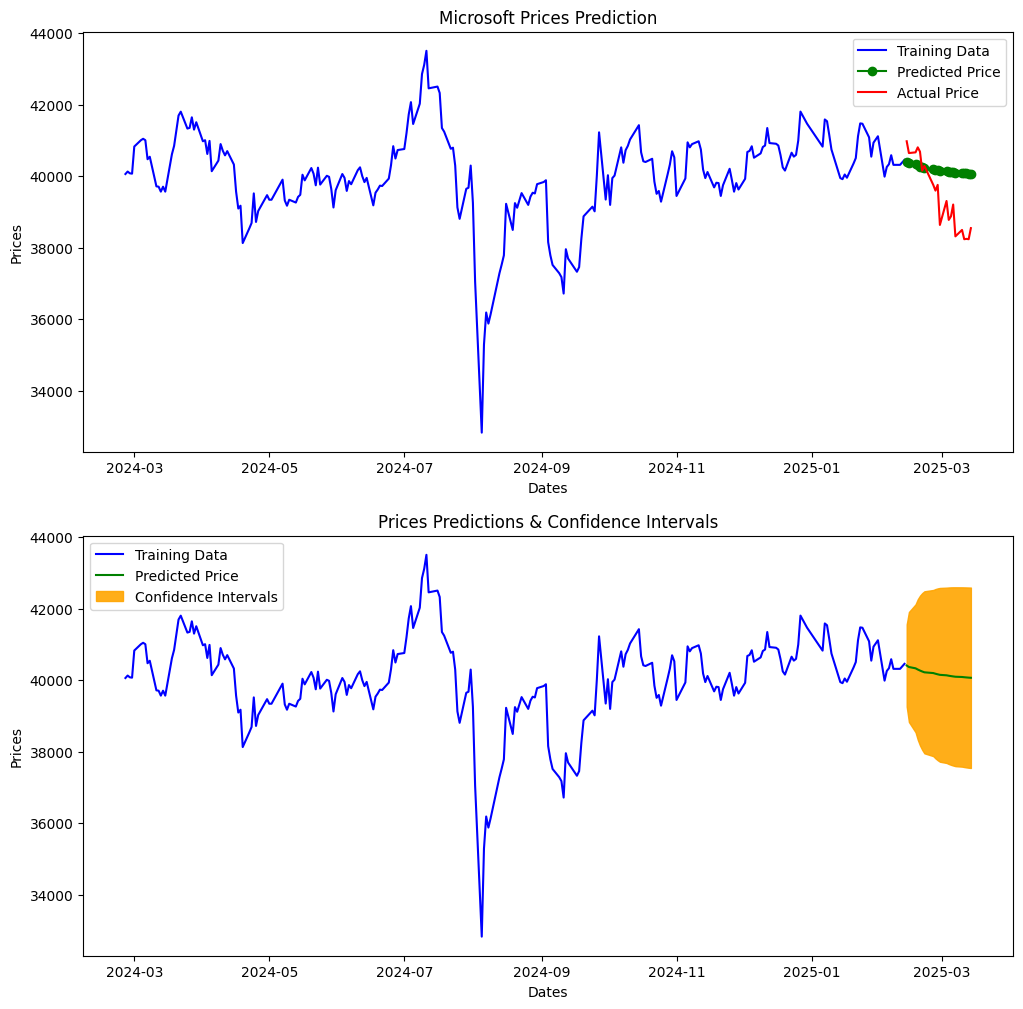

In [32]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import ndiffs
from pandas.plotting import lag_plot
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape


# Function to fit the ARIMA model
def fit_arima_model(stock_data, forecast_steps):
    warnings.filterwarnings("ignore")
    kpss_diffs = ndiffs(stock_data, alpha=0.05, test='kpss', max_d=6)
    adf_diffs = ndiffs(stock_data, alpha=0.05, test='adf', max_d=6)
    n_diffs = max(adf_diffs, kpss_diffs)

    print(f"Estimated differencing term: {n_diffs}")


    auto_model=auto_arima(stock_data, d=n_diffs, seasonal=False, stepwise=True,
                      suppress_warnings=True, error_action="ignore",information_criterion='bic',
                      max_order=None, trace=True)

    # Get the best ARIMA order
    p, d, q = auto_model.order  # d is already determined above
    print(f"Best ARIMA Order: p={p}, d={d}, q={q}")
    return auto_model


def forecast(model,forecast_steps):
 fc, conf_int = model.predict(n_periods=forecast_steps, return_conf_int=True)
 return (
     fc.tolist(),
     np.asarray(conf_int).tolist())


# Function to test ARIMA forecasts
def test_arima_forecasts(df, forecast_steps=21):
    warnings.filterwarnings("ignore")

    train_len = df.shape[0]-forecast_steps
    train_data, test_data = df[:train_len], df[train_len:]

    y_train = train_data.values
    y_test = test_data.values

    print(f"{train_len} train samples")
    print(f"{df.shape[0] - train_len} test samples")

    # fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    # plt.title('Autocorrelation plot')

    # # The axis coordinates for the plots
    # ax_idcs = [
    #     (0, 0),
    #     (0, 1),
    #     (1, 0),
    #     (1, 1),
    #     (2, 0),
    #     (2, 1)
    # ]

    # for lag, ax_coords in enumerate(ax_idcs, 1):
    #     ax_row, ax_col = ax_coords
    #     axis = axes[ax_row][ax_col]
    #     lag_plot(df, lag=lag, ax=axis)
    #     axis.set_title(f"Lag={lag}")

    # plt.show()

    """All lags look fairly linear, so it's a good indicator that an auto-regressive model is a good choice.
    Therefore, we'll allow the `auto_arima` to select the lag term for us, up to 6."""

    model=fit_arima_model(y_train, forecast_steps)

    fc, conf = forecast(model=model, forecast_steps=forecast_steps)

    print("fc\n:")
    print(fc)
    print("conf\n:")
    print(conf)


    print(f"Mean squared error: {mean_squared_error(y_test, fc)}")
    print(f"SMAPE: {smape(y_test, fc)}")


    fig, axes = plt.subplots(2, 1, figsize=(12, 12))

    # --------------------- Actual vs. Predicted --------------------------
    axes[0].plot(train_data.index,y_train, color='blue', label='Training Data')
    axes[0].plot(test_data.index, fc, color='green', marker='o',
                 label='Predicted Price')

    axes[0].plot(test_data.index, y_test, color='red', label='Actual Price')
    axes[0].set_title('Microsoft Prices Prediction')
    axes[0].set_xlabel('Dates')
    axes[0].set_ylabel('Prices')

    #axes[0].set_xticks(np.arange(0, 7982, 1300).tolist(), df['Date'][0:7982:1300].tolist())
    axes[0].legend()


    # ------------------ Predicted with confidence intervals ----------------
    axes[1].plot(train_data.index,y_train, color='blue', label='Training Data')
    axes[1].plot(test_data.index, fc, color='green',
                 label='Predicted Price')

    axes[1].set_title('Prices Predictions & Confidence Intervals')
    axes[1].set_xlabel('Dates')
    axes[1].set_ylabel('Prices')

    conf_int = np.asarray(conf)
    axes[1].fill_between(test_data.index,
                         conf_int[:, 0], conf_int[:, 1],
                         alpha=0.9, color='orange',
                         label="Confidence Intervals")

    #axes[1].set_xticks(np.arange(0, 7982, 1300).tolist(), df['Date'][0:7982:1300].tolist())
    axes[1].legend()

# Example usage:
# stock_data = pd.read_csv("your_stock_data.csv", index_col="Date", parse_dates=True)
# test_arima_forecasts(stock_data, forecast_steps=21)

test_arima_forecasts(stock_data['Close'])

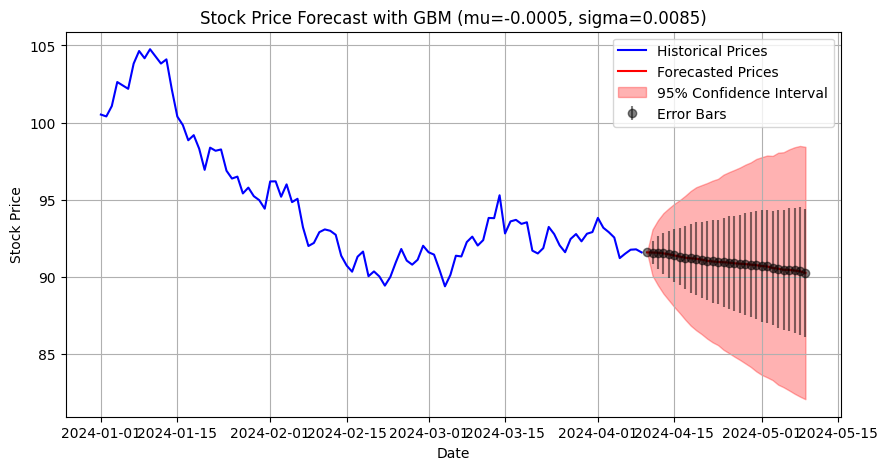

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_weighted_parameters(df, column, span):
    """
    Computes weighted moving average drift (mu) and weighted standard deviation (sigma) using EWMA.
    """
    log_returns = np.log(df[column] / df[column].shift(1))
    mu = log_returns.ewm(span=span).mean().iloc[-1]  # EWMA mean of log-returns
    sigma = log_returns.ewm(span=span).std().iloc[-1]  # EWMA std deviation
    return mu, sigma

def geometric_brownian_motion_forecast(df, column, Y, N, span):
    """
    Uses last X days of historical data to forecast Y days ahead using GBM with weighted drift and volatility.
    """
    mu, sigma = compute_weighted_parameters(df, column, span)
    S_hist = df[column].values
    S0 = S_hist[-1]  # Last known price
    S = np.zeros((Y, N))
    S[0] = S0

    for i in range(1, Y):
        dW = np.random.normal(0, 1, N)  # Brownian motion increment
        S[i] = S[i-1] * np.exp((mu - 0.5 * sigma**2) + sigma * dW)

    return S, mu, sigma

# Parameters
X = 100       # Use last 100 days of historical data
Y = 30        # Predict next 30 days
span = 50     # EWMA span for weighted drift & volatility
N = 1000      # Number of simulation paths

# Generate synthetic historical data (for demonstration)
np.random.seed(42)
dates = pd.date_range(start="2024-01-01", periods=X)
prices = np.cumprod(1 + np.random.normal(0.0002, 0.01, X)) * 100
df = pd.DataFrame({"Date": dates, "Price": prices})

# Run forecast
S_forecast, mu, sigma = geometric_brownian_motion_forecast(df, "Price", Y, N, span)

# Compute mean and confidence intervals
S_mean = np.mean(S_forecast, axis=1)
S_std = np.std(S_forecast, axis=1)
conf_interval = 1.96 * S_std  # 95% confidence interval

# Extend dates for forecast
future_dates = pd.date_range(start=df["Date"].iloc[-1], periods=Y+1)[1:]

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(df["Date"], df["Price"], label="Historical Prices", color="blue")
plt.plot(future_dates, S_mean, label="Forecasted Prices", color="red")
plt.fill_between(future_dates, S_mean - conf_interval, S_mean + conf_interval, color='red', alpha=0.3, label="95% Confidence Interval")
plt.errorbar(future_dates, S_mean, yerr=S_std, fmt='o', color='black', alpha=0.5, label="Error Bars")
plt.title(f"Stock Price Forecast with GBM (mu={mu:.4f}, sigma={sigma:.4f})")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.grid()
plt.show()


In [ ]:
from tqdm import tqdm  # Import tqdm for the progress bar

import pandas as pd

def precompute_arima_forecasts(stock_data, lookback_period=252, forecast_steps=21):
    # Initialize lists to store forecasts, confidence intervals, and levels
    forecasts = []
    conf_intervals = []

    # Precompute forecasts with a progress bar
    for i in tqdm(range(lookback_period, len(stock_data)), desc="Precomputing ARIMA Forecasts"):
        # Extract the rolling window data
        window_data = stock_data.iloc[i - lookback_period:i]

        arima_result = fit_arima_model(window_data)
        forecast = arima_result.get_forecast(steps=forecast_steps)
        forecasted_values = forecast.predicted_mean
        conf_int = forecast.conf_int()  # Confidence intervals

        # Append results to lists
        forecasts.append(forecasted_values.values)
        conf_intervals.append(conf_int.values)

    # Create a DataFrame to store the results
    results = pd.DataFrame({
        'Date': stock_data.index[lookback_period:],
        'Forecast': forecasts,
        'Confidence_Interval_Lower': [x[0][0] for x in conf_intervals],
        'Confidence_Interval_Upper': [x[0][1] for x in conf_intervals],
    })

    # Save the results to a CSV file
    results.to_csv(f'{stock_data.name}_arima_forecasts.csv', index=False)

precompute_arima_forecasts(stock_data=stock_data)

Precomputing ARIMA Forecasts:   0%|          | 0/247 [00:00<?, ?it/s]

ADF Statistic: -0.17560806297295078
p-value: 0.9413673035389506
Data is not stationary. Apply differencing or transformations.
Applied differencing to make data stationary.
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1307.674, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1304.986, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1305.826, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1305.527, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1306.341, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1300.864, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1302.329, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1302.149, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1302.810, Time=0.10 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.619 seconds
Best ARIMA Order: p=0, d=0, q=0


Precomputing ARIMA Forecasts:   0%|          | 1/247 [00:00<02:57,  1.39it/s]

ARIMA Forecast (Auto-Selected p=0, d=0, q=0)
ADF Statistic: 0.06624720552932103
p-value: 0.9636796315147345
Data is not stationary. Apply differencing or transformations.
Applied differencing to make data stationary.
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1306.455, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1304.685, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1304.807, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1304.337, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1305.264, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1304.406, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1306.392, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1301.253, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1300.588, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1301.584, Time=0.06 sec


Precomputing ARIMA Forecasts:   1%|          | 2/247 [00:01<03:16,  1.24it/s]

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1301.933, Time=0.13 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.762 seconds
Best ARIMA Order: p=0, d=0, q=0
ARIMA Forecast (Auto-Selected p=0, d=0, q=0)
ADF Statistic: 0.15100757149885785
p-value: 0.9693759468686095
Data is not stationary. Apply differencing or transformations.
Applied differencing to make data stationary.
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1302.839, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1300.736, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1300.583, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1300.100, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1301.064, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1300.420, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1302.416, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1296.209, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   :

Precomputing ARIMA Forecasts:   1%|          | 3/247 [00:02<03:36,  1.13it/s]

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1296.881, Time=0.13 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.890 seconds
Best ARIMA Order: p=0, d=0, q=0
ARIMA Forecast (Auto-Selected p=0, d=0, q=0)
ADF Statistic: 0.10634334310298822
p-value: 0.9664915244503867
Data is not stationary. Apply differencing or transformations.
Applied differencing to make data stationary.
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1302.870, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1300.726, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1300.646, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1300.164, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1301.073, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1300.394, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1302.390, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1296.448, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   :

Precomputing ARIMA Forecasts:   2%|▏         | 4/247 [00:03<03:35,  1.13it/s]

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1297.061, Time=0.13 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.783 seconds
Best ARIMA Order: p=0, d=0, q=0
ARIMA Forecast (Auto-Selected p=0, d=0, q=0)
ADF Statistic: -0.014656848652058078
p-value: 0.9573030598481098
Data is not stationary. Apply differencing or transformations.
Applied differencing to make data stationary.
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1302.438, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1300.309, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1300.233, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1299.757, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1300.751, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1300.031, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1302.013, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1296.388, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept  

Precomputing ARIMA Forecasts:   2%|▏         | 5/247 [00:04<03:39,  1.10it/s]

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1297.092, Time=0.16 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.846 seconds
Best ARIMA Order: p=0, d=0, q=0
ARIMA Forecast (Auto-Selected p=0, d=0, q=0)
ADF Statistic: 0.0947901312443333
p-value: 0.965703586815412
Data is not stationary. Apply differencing or transformations.
Applied differencing to make data stationary.
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1302.417, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1300.346, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1300.237, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1299.744, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1300.698, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1299.937, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1301.914, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1296.543, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : A

Precomputing ARIMA Forecasts:   2%|▏         | 6/247 [00:05<03:29,  1.15it/s]

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1297.230, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.659 seconds
Best ARIMA Order: p=0, d=0, q=0
ARIMA Forecast (Auto-Selected p=0, d=0, q=0)
ADF Statistic: 0.30705202938411413
p-value: 0.9776657258940108
Data is not stationary. Apply differencing or transformations.
Applied differencing to make data stationary.
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1304.053, Time=0.64 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1302.072, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1301.939, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1301.425, Time=0.54 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1302.347, Time=0.68 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1301.592, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1303.574, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1297.739, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   :

Precomputing ARIMA Forecasts:   3%|▎         | 7/247 [00:08<06:23,  1.60s/it]

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1298.369, Time=0.42 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 2.962 seconds
Best ARIMA Order: p=0, d=0, q=0
ARIMA Forecast (Auto-Selected p=0, d=0, q=0)
ADF Statistic: 0.45507728113882157
p-value: 0.9834418185818515
Data is not stationary. Apply differencing or transformations.
Applied differencing to make data stationary.
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1301.457, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1299.024, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1299.110, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1298.585, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1299.300, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1298.218, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1300.190, Time=0.15 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1300.148, Time=0.05 sec
 ARIMA(1,0,3)(0,0,0)[0]             :

Precomputing ARIMA Forecasts:   3%|▎         | 8/247 [00:10<06:55,  1.74s/it]

 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=1297.050, Time=0.23 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0] intercept
Total fit time: 1.936 seconds
Best ARIMA Order: p=0, d=0, q=2
ARIMA Forecast (Auto-Selected p=0, d=0, q=2)
ADF Statistic: 0.44766684856587974
p-value: 0.9831926117178932
Data is not stationary. Apply differencing or transformations.
Applied differencing to make data stationary.
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1300.427, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1298.591, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1298.863, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1298.366, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1299.021, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1297.857, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1299.836, Time=0.07 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1299.805, Time=0.05 sec
 ARIMA(1,0,3)(0,0,0)[0]             :

Precomputing ARIMA Forecasts:   4%|▎         | 9/247 [00:12<07:13,  1.82s/it]

 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=1296.899, Time=0.25 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0] intercept
Total fit time: 1.905 seconds
Best ARIMA Order: p=0, d=0, q=2
ARIMA Forecast (Auto-Selected p=0, d=0, q=2)
ADF Statistic: 0.20622189820884848
p-value: 0.9726084101042398
Data is not stationary. Apply differencing or transformations.
Applied differencing to make data stationary.
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1299.485, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1296.628, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1296.975, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1296.527, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1297.301, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1296.218, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1298.191, Time=0.07 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1298.150, Time=0.05 sec


Precomputing ARIMA Forecasts:   4%|▎         | 9/247 [00:13<05:54,  1.49s/it]

 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.45 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1292.632, Time=0.10 sec


KeyboardInterrupt: 

In [ ]:
import backtrader as bt
import pandas as pd
import yfinance as yf
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import warnings

# 📌 Step 2: Backtrader Strategy with Dynamic Data Access
class RollingARIMAStrategy(bt.Strategy):
    params = (
        ('lookback_period', 252),  # Default lookback period (1 year of trading days)
        ('forecast_steps', 21),  # Forecast 1 day ahead
    )

    def __init__(self):
        self.data_close = self.data.close  # Access closing prices

    def next(self):
        # Print progress
        print(f"Step: {len(self.data_close)} | Portfolio Value: {self.broker.getvalue():.2f}")
        # Check if we have enough data for the lookback period

        if len(self.data_close) > self.params.lookback_period:
            # Extract the most recent `lookback_period` data points
            window_data = self.data_close.get(size=self.params.lookback_period)

            # Convert window_data to a pandas Series
            window_data = pd.Series(window_data)

            arima_result = fit_arima_model(window_data)

            # Forecast the next `forecast_steps` days
            forecast = arima_result.forecast(steps=self.params.forecast_steps)
            forecasted_price = forecast.max()  # Get the forecasted price

            # Trading logic
            current_price = self.data_close[0]
            if forecasted_price > current_price:
                self.buy()  # Buy signal
            elif forecasted_price < current_price:
                self.sell()  # Sell signal

    def notify_trade(self, trade):
        # Print trade details when a trade is opened or closed
        if trade.isclosed:
            print(f"TRADE CLOSED: {trade.data._name} | PnL: {trade.pnl:.2f} | Commission: {trade.commission:.2f}")
        elif trade.justopened:
            print(f"TRADE OPENED: {trade.data._name} | Size: {trade.size} | Price: {trade.price:.2f}")

    def notify_order(self, order):
        # Print order details when an order is executed
        if order.status in [order.Completed, order.Canceled, order.Margin]:
            print(f"ORDER EXECUTED: {order.data._name} | Size: {order.size} | Price: {order.executed.price:.2f}")

# 📌 Step 3: Backtest the Strategy
if __name__ == '__main__':
    # Create a Cerebro engine instance
    cerebro = bt.Cerebro()

    # Add the strategy to Cerebro with custom parameters
    cerebro.addstrategy(
        RollingARIMAStrategy,
        lookback_period=252,  # 1 year of trading days
        forecast_steps=1  # Forecast 1 day ahead
    )

    # Prepare the data for Backtrader
    stock_data.reset_index(inplace=True)
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])
    stock_data.set_index('Date', inplace=True)
    data = bt.feeds.PandasData(dataname=stock_data)

    # Add the data to Cerebro
    cerebro.adddata(data)

    # Set the initial cash
    cerebro.broker.set_cash(10000.0)

    # Set the commission (optional)
    cerebro.broker.setcommission(commission=0.001)

    # Run the backtest
    print("Starting Portfolio Value: %.2f" % cerebro.broker.getvalue())
    cerebro.run()
    print("Final Portfolio Value: %.2f" % cerebro.broker.getvalue())

    # Plot the results
    cerebro.plot()

Starting Portfolio Value: 10000.00
Step: 1 | Portfolio Value: 10000.00
Step: 2 | Portfolio Value: 10000.00
Step: 3 | Portfolio Value: 10000.00
Step: 4 | Portfolio Value: 10000.00
Step: 5 | Portfolio Value: 10000.00
Step: 6 | Portfolio Value: 10000.00
Step: 7 | Portfolio Value: 10000.00
Step: 8 | Portfolio Value: 10000.00
Step: 9 | Portfolio Value: 10000.00
Step: 10 | Portfolio Value: 10000.00
Step: 11 | Portfolio Value: 10000.00
Step: 12 | Portfolio Value: 10000.00
Step: 13 | Portfolio Value: 10000.00
Step: 14 | Portfolio Value: 10000.00
Step: 15 | Portfolio Value: 10000.00
Step: 16 | Portfolio Value: 10000.00
Step: 17 | Portfolio Value: 10000.00
Step: 18 | Portfolio Value: 10000.00
Step: 19 | Portfolio Value: 10000.00
Step: 20 | Portfolio Value: 10000.00
Step: 21 | Portfolio Value: 10000.00
Step: 22 | Portfolio Value: 10000.00
Step: 23 | Portfolio Value: 10000.00
Step: 24 | Portfolio Value: 10000.00
Step: 25 | Portfolio Value: 10000.00
Step: 26 | Portfolio Value: 10000.00
Step: 27 | P

KeyboardInterrupt: 